# Importing Libraries

In [1]:
import numpy as np  #importing numerical python library for mathematical functions
import pandas as pd  #importing python data analysis library ?

# Importing Data

In [2]:
df=pd.read_csv('/kaggle/input/ui-transactions-new/user_item_transactions_merged.csv', dtype={
    'mbr_card' : str,
    'prod_code' : str
    })  #Reading csv file of data
df

,mbr_card,prod_code,transaction_value
0,%004560450,0511892,494000.0
1,%004560450,0904139,40090.0
2,%004610940,0601795,56240.0
3,%050824440,0203241,30530.0
4,%050824440,0402853,27006.0
...,...,...,...
2020119,C@!)^))#)(,0202943,159600.0
2020120,C@!)^))#)(,0203312,78848.0
2020121,CZ10600111,0200803,55290.0
2020122,CZ10600111,0201895,96330.0


In [3]:
# Get only the user with more than 10 transactions
df = df.groupby('mbr_card').filter(lambda x: len(x) >= 10)
df

,mbr_card,prod_code,transaction_value
3,%050824440,0203241,30530.0
4,%050824440,0402853,27006.0
5,%050824440,0404050,47180.0
6,%050824440,0514598,103600.0
7,%050824440,0515657,330732.0
...,...,...,...
2020114,C220502269,2400201,89205.0
2020115,C220502269,2400202,76095.0
2020116,C220502269,2400203,25650.0
2020117,C220502269,3400001,1996.0


In [4]:
from sklearn.preprocessing import MinMaxScaler

df["transaction_value"] = np.log1p(df["transaction_value"])
scaler = MinMaxScaler(feature_range=(1, 5))
df["transaction_value"] = scaler.fit_transform(df["transaction_value"].values.reshape(-1,1))


In [5]:
df

,mbr_card,prod_code,transaction_value
3,%050824440,0203241,2.426183
4,%050824440,0402853,2.395452
5,%050824440,0404050,2.535243
6,%050824440,0514598,2.732330
7,%050824440,0515657,3.023182
...,...,...,...
2020114,C220502269,2400201,2.694845
2020115,C220502269,2400202,2.655016
2020116,C220502269,2400203,2.382544
2020117,C220502269,3400001,1.742856


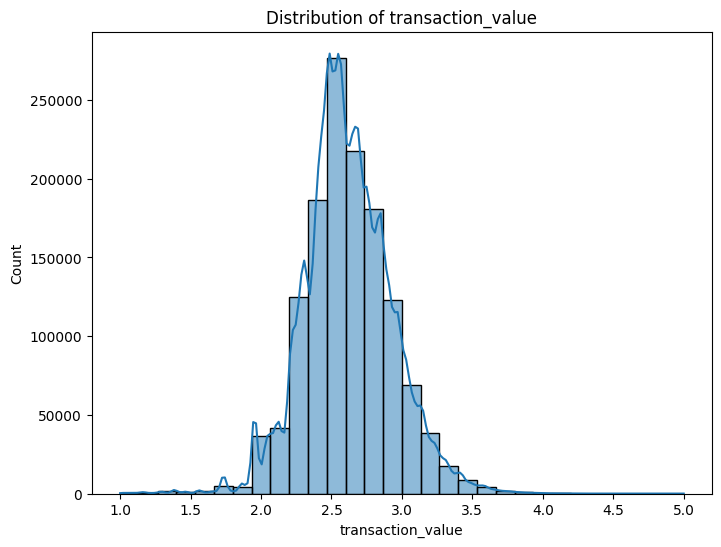

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
numerical_features = df.select_dtypes(include=['int', 'float']).columns

for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


In [7]:
Q1 = df['transaction_value'].quantile(0.25)
Q3 = df['transaction_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['transaction_value'] < lower_bound) | (df['transaction_value'] > upper_bound)]
print(outliers)

           mbr_card prod_code  transaction_value
146      0000000000   0105253           3.488658
179      0000000000   0108877           3.400680
184      0000000000   0109328           3.490471
497      0000000000   2800443           1.730512
552      0000001072   0109815           3.458606
...             ...       ...                ...
2019793  AV00073466   2800444           1.730512
2019863  AV00073833   2800443           1.730512
2020089  C210600170   0304979           3.431981
2020113  C220502269   0403216           1.658647
2020117  C220502269   3400001           1.742856

[26194 rows x 3 columns]


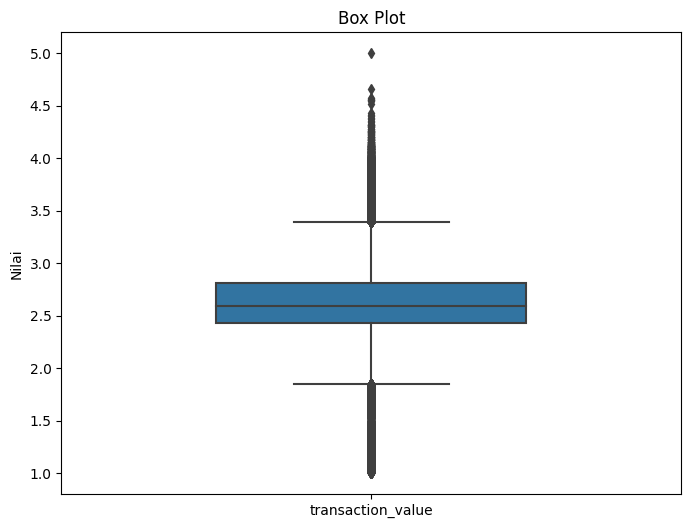

In [8]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, orient='vertical', width=0.5)
plt.title('Box Plot')
plt.ylabel('Nilai')
plt.show()

In [9]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import NMF
from surprise import accuracy

In [10]:
df

,mbr_card,prod_code,transaction_value
3,%050824440,0203241,2.426183
4,%050824440,0402853,2.395452
5,%050824440,0404050,2.535243
6,%050824440,0514598,2.732330
7,%050824440,0515657,3.023182
...,...,...,...
2020114,C220502269,2400201,2.694845
2020115,C220502269,2400202,2.655016
2020116,C220502269,2400203,2.382544
2020117,C220502269,3400001,1.742856


In [11]:
reader = Reader(rating_scale=(df['transaction_value'].min(), df['transaction_value'].max()))

In [12]:
reader

In [13]:
df_surprise = Dataset.load_from_df(df[['mbr_card', 'prod_code', 'transaction_value']], reader)

In [14]:
df_surprise

In [15]:
train, test = train_test_split(df_surprise, test_size=0.2, random_state=42)

In [16]:
model = NMF()

In [17]:
model.fit(train)

In [18]:
predictions = model.test(test)

In [19]:
rmse = accuracy.rmse(predictions)
print("RMSE untuk data test:", rmse)

RMSE: 0.1549
RMSE untuk data test: 0.15491616616382536


In [20]:
scaler

MinMaxScaler(feature_range=(1, 5))

In [21]:
test = pd.DataFrame({
    'actual_rating' : [p.r_ui for p in predictions],
    'predicted_rating' : [p.est for p in predictions]
})

In [22]:
test["predicted_rating"] = scaler.inverse_transform(test['predicted_rating'].values.reshape(-1,1))
test["predicted_rating"] = np.exp(test['predicted_rating']) - 1
test["actual_rating"] = scaler.inverse_transform(test['actual_rating'].values.reshape(-1,1))
test["actual_rating"] = np.exp(test['actual_rating']) - 1

In [23]:
test

,actual_rating,predicted_rating
0,232890.0,21332.360631
1,60000.0,46837.800126
2,170050.0,211252.930997
3,309700.0,435045.824234
4,31730.0,35392.016328
...,...,...
268277,281200.0,285388.672124
268278,222000.0,184472.131733
268279,120700.0,236284.282915
268280,39424.0,30053.671493


In [24]:
import pandas as pd
import random

def random_sample_predictions(predictions_df, n=10):
    # Ensure the input DataFrame is sorted randomly
    predictions_df = predictions_df.sample(frac=1).reset_index(drop=True)
    
    print(f"{'Actual Rating':<15}{'Predicted Rating':<18}{'Rating Difference':<18}")
    print("="*55)
    
    for i in range(min(n, len(predictions_df))):
        actual_rating = predictions_df.loc[i, 'actual_rating']
        predicted_rating = predictions_df.loc[i, 'predicted_rating']
        rating_difference = abs(actual_rating - predicted_rating)
        
        print(f"{actual_rating:<15.2f}{predicted_rating:<18.2f}{rating_difference:<18.2f}")



In [25]:
random_sample_predictions(test, 10)

Actual Rating  Predicted Rating  Rating Difference 
58140.00       27159.37          30980.63          
32110.00       27422.69          4687.31           
373000.00      74745.69          298254.31         
129500.00      157856.23         28356.23          
61940.00       56067.75          5872.25           
42940.00       66014.53          23074.53          
473100.00      885508.52         412408.52         
88800.00       45884.32          42915.68          
48640.00       106263.42         57623.42          
78848.00       27213.60          51634.40          


In [26]:
test["diff"] = abs(test["actual_rating"] - test["predicted_rating"])

In [27]:
test["diff"].max()

143152597.78074077

In [28]:
test["diff"].min()

0.011061152011279773

<Axes: >

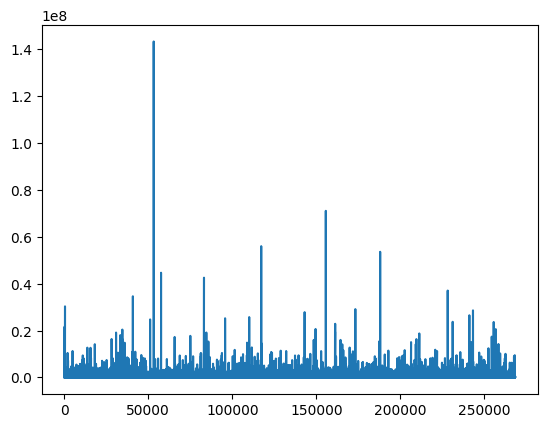

In [29]:
test["diff"].plot()

In [30]:
from surprise.model_selection import cross_validate

cross_validate(model, df_surprise, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1547  0.1552  0.1550  0.1545  0.1554  0.1550  0.0003  
MAE (testset)     0.1117  0.1117  0.1119  0.1115  0.1119  0.1117  0.0002  
Fit time          44.09   45.67   45.80   46.17   45.82   45.51   0.73    
Test time         4.10    3.33    3.40    3.35    3.99    3.63    0.34    


{'test_rmse': array([0.15473959, 0.15519978, 0.15503705, 0.15454677, 0.1554461 ]),
 'test_mae': array([0.11167424, 0.11170076, 0.11189734, 0.11149604, 0.11193402]),
 'fit_time': (44.088889837265015,
  45.67279124259949,
  45.80470299720764,
  46.17466950416565,
  45.82231640815735),
 'test_time': (4.09509801864624,
  3.330073356628418,
  3.398149013519287,
  3.345358371734619,
  3.993243455886841)}

In [31]:
test["diff_rate"] = test["diff"] / test["actual_rating"] 

In [32]:
test["diff_rate"].mean()

0.499606347534859